In [115]:
libraries = c("dplyr", "tidyverse", "ggpubr", "rworldmap")
for(x in libraries) {library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE)}

theme_set(theme_bw())

In [119]:
## MPX incidence data
read.csv("https://raw.githubusercontent.com/globaldothealth/monkeypox/main/timeseries-country-confirmed-deprecated.csv") -> df_inci
df_inci$Date <- as.Date(df_inci$Date)

df_inci %>% arrange(Date) %>% group_by(Country) %>% filter(rank(Date)==1) %>% 
dplyr::select(Country, Date) %>% rename(date_import = Date) -> temp
merge(df_inci, temp, by=c("Country"), all.x=TRUE) -> df_inci

## merging ISO code for each country
read.csv("../data/incidence/owid-monkeypox-data.csv") -> temp
temp %>% dplyr::select(location, iso_code) %>% rename(Country=location) %>% distinct() -> iso_code_list
merge(df_inci, iso_code_list, by=c("Country"), all.x=TRUE) %>%
mutate(iso_code=case_when(Country==c("Bosnia And Herzegovina") ~ c("BIH"),
                          Country==c("Curaçao") ~ c("CUW"),
                          Country==c("Czech Republic") ~ c("CZE"),
                          Country==c("Democratic Republic Of The Congo") ~ c("COD"),
                          Country==c("Hong Kong") ~ c("HKG"),
                          Country==c("Republic of Congo") ~ c("COG"),
                          Country==c("South Sudan") ~ c("SSD"),
                          Country==c("Taiwan") ~ c("TWN"),
                          TRUE ~ iso_code)) -> df_inci

write.csv(df_inci, "../data/incidence/df_inci_Github.csv")

In [122]:
## MPX incidence data (without China)
read.csv("https://raw.githubusercontent.com/globaldothealth/monkeypox/main/timeseries-country-confirmed-deprecated.csv") -> df_inci
df_inci$Date <- as.Date(df_inci$Date)
df_inci %>% filter(!(Country %in% c("China"))) -> df_inci

read.csv("../data/incidence/owid-monkeypox-data.csv") -> df_worldin
df_worldin %>% filter(location==c("China")) %>% 
dplyr::select(location, date, new_cases, total_cases) %>%
rename(Country=location, Date=date, Cases=new_cases, Cumulative_cases=total_cases) -> temp_China

rbind(df_inci, temp_China) -> df_inci ## China data was corrected following Worldin data

df_inci %>% arrange(Date) %>% group_by(Country) %>% filter(rank(Date)==1) %>% 
dplyr::select(Country, Date) %>% rename(date_import = Date) -> temp
merge(df_inci, temp, by=c("Country"), all.x=TRUE) -> df_inci

## merging ISO code for each country
df_worldin %>% dplyr::select(location, iso_code) %>% rename(Country=location) %>% distinct() -> iso_code_list
merge(df_inci, iso_code_list, by=c("Country"), all.x=TRUE) %>%
mutate(iso_code=case_when(Country==c("Bosnia And Herzegovina") ~ c("BIH"),
                          Country==c("Curaçao") ~ c("CUW"),
                          Country==c("Czech Republic") ~ c("CZE"),
                          Country==c("Democratic Republic Of The Congo") ~ c("COD"),
                          Country==c("Hong Kong") ~ c("HKG"),
                          Country==c("Republic of Congo") ~ c("COG"),
                          Country==c("South Sudan") ~ c("SSD"),
                          Country==c("Taiwan") ~ c("TWN"),
                          TRUE ~ iso_code)) -> df_inci

write.csv(df_inci, "../data/incidence/df_inci_Github.csv")

In [123]:
## MSM population
read.csv("../data/MSM_pop/df_MSM_UNAIDS.csv") -> df_MSM1
read.csv("../data/MSM_pop/df_full_list_MSMsize_Fumi.csv") -> df_MSM2

## revising the pop2022 column from df_MSM2
read.csv("../data/MSM_pop/df_pop_raw.csv") %>% dplyr::select(cca2, pop2022) %>% rename(iso_2=cca2) -> df_pop1
read.csv("../data/MSM_pop/df_region.csv") %>% dplyr::select(alpha.2,alpha.3, name) %>%
rename(iso_2=alpha.2, iso_code=alpha.3, location=name) -> df_pop2
merge(df_pop1, df_pop2, by=c("iso_2")) -> df_pop
merge(df_MSM2 %>% dplyr::select(-pop2022), 
      df_pop %>% dplyr::select(iso_code, pop2022), by=c("iso_code"), all.x=TRUE) -> df_MSM2

## giving a priority to UNAIDS dashboard
merge(df_MSM1, df_MSM2, by=c("location"),all=TRUE) %>% 
dplyr::select(location, iso_code, estimate, MSM_size, region, sub_region, pop2022) %>%
mutate(prop=estimate/pop2022) %>%
mutate(imputed=case_when(!is.na(estimate) ~ estimate, is.na(estimate) & !is.na(MSM_size) ~ MSM_size), 
       prop=imputed/pop2022) -> temp

## imputation of missing values
temp %>% group_by(sub_region) %>% drop_na(imputed) %>% summarise(prop_avg = mean(prop)) -> prop_avg
merge(temp, prop_avg, by=c("sub_region"), all.x=TRUE) %>% drop_na(pop2022) %>%
mutate(prop=case_when(!is.na(prop)~prop, is.na(prop)~prop_avg),
       imputed=case_when(!is.na(imputed)~imputed, is.na(imputed)~prop*pop2022)) -> df_MSM_imputed


## modifying Samoa with the UNAIDS report
df_MSM_imputed %>% mutate(imputed=case_when(location==c("Samoa")~MSM_size, TRUE~imputed),
                          prop=case_when(location==c("Samoa")~MSM_size/pop2022, TRUE~prop)) -> df_MSM_imputed

df_MSM_imputed %>% head()
write.csv(df_MSM_imputed, "../data/MSM_pop/df_MSM_imputed.csv")

,sub_region,location,iso_code,estimate,MSM_size,region,pop2022,prop,imputed,prop_avg
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Australia and New Zealand,New Zealand,NZL,37.5,84.52019,Oceania,5185.288,0.007231999,37.5000,0.008648965
2,Australia and New Zealand,Australia,AUS,263.5,426.69183,Oceania,26177.413,0.010065930,263.5000,0.008648965
3,Central Asia,Turkmenistan,TKM,NA,135.68925,Asia,6430.770,0.021100000,135.6892,0.009858269
4,Central Asia,Tajikistan,TJK,13.4,210.00381,Asia,9952.787,0.001346357,13.4000,0.009858269
5,Central Asia,Uzbekistan,UZB,NA,730.64346,Asia,34627.652,0.021100000,730.6435,0.009858269
6,Central Asia,Kazakhstan,KAZ,62.0,409.29776,Asia,19397.998,0.003196206,62.0000,0.009858269


In [124]:
## merging incidence and MSM population data
merge(df_inci, df_MSM_imputed %>% dplyr::select(iso_code, imputed, pop2022, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) -> df_all_inci
write.csv(df_all_inci, "../data/MSM_pop/df_all_inci_Github.csv")

228 codes from your data successfully matched countries in the map
6 codes from your data failed to match with a country code in the map
15 codes from the map weren't represented in your data


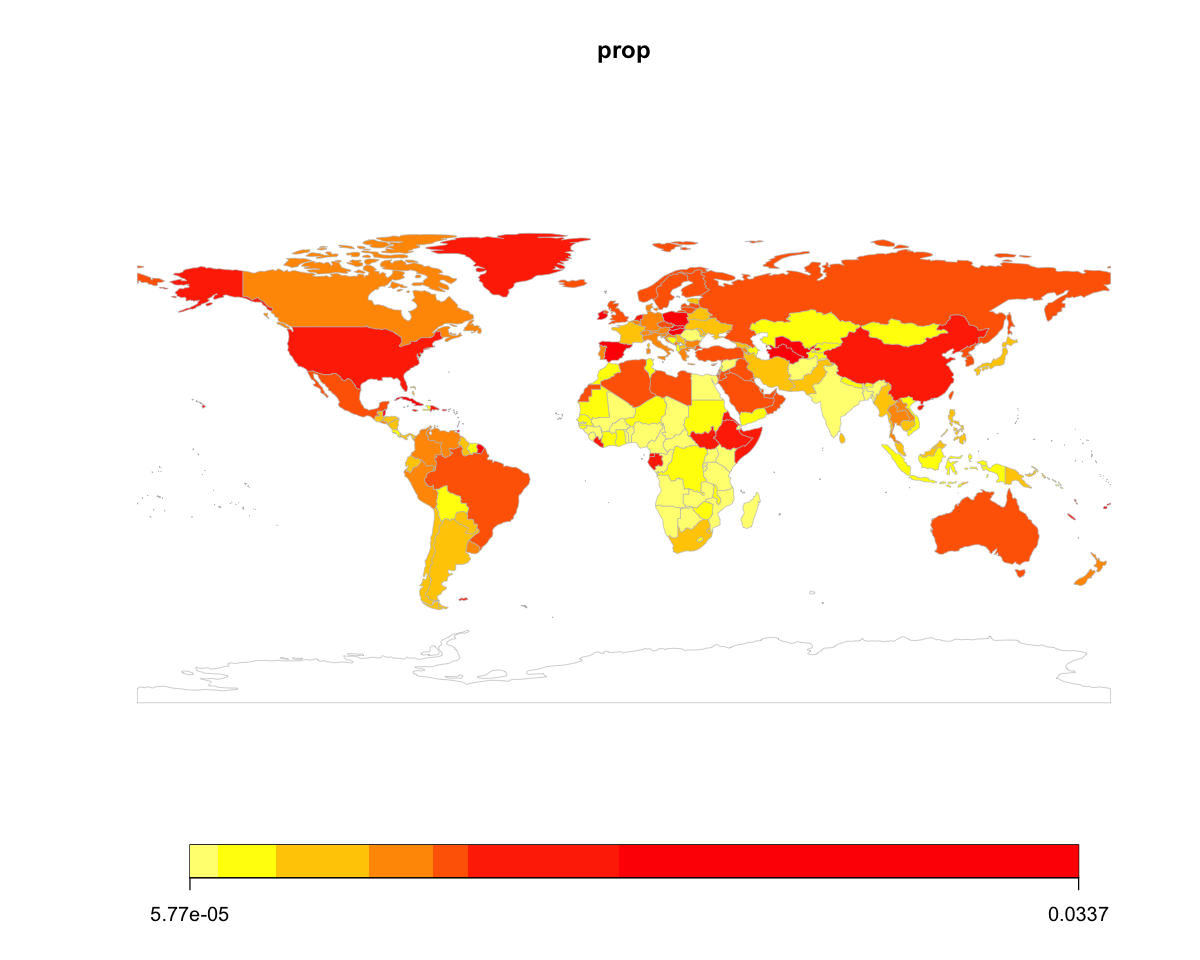

In [125]:
## figure for the proportion of MSM among total population
options(repr.plot.width=10,repr.plot.height=8)
df_MSM_imputed %>% dplyr::select(iso_code, prop) -> fig_MSM
Map = joinCountryData2Map(fig_MSM, joinCode = "ISO3", nameJoinColumn ="iso_code", mapResolution = "coarse") 
mapCountryData(Map, nameColumnToPlot="prop")

In [126]:
## adding data with zero case from day 0
as.data.frame(seq(min(df_all_inci$Date), max(df_all_inci$Date), 1)) -> temp_cal; colnames(temp_cal) <- c("Date") 
unique(df_all_inci$Country) -> MPX_country_list

df_inci_list <- list()
for(i in 1:length(MPX_country_list)){
    df_all_inci %>% filter(Country==MPX_country_list[i]) -> temp_inci
    merge(temp_cal, temp_inci, by=c("Date"), all.x=TRUE) -> temp_inci_all

    temp_inci_all$Country[is.na(temp_inci_all$Country)] <- unique(temp_inci$Country)
    temp_inci_all$iso_code[is.na(temp_inci_all$iso_code)] <- unique(temp_inci$iso_code)
    temp_inci_all$region[is.na(temp_inci_all$region)] <- unique(temp_inci$region)
    temp_inci_all$sub_region[is.na(temp_inci_all$sub_region)] <- unique(temp_inci$sub_region)
    temp_inci_all$Cases[is.na(temp_inci_all$Cases)] <- 0
    temp_inci_all$Cumulative_cases[is.na(temp_inci_all$Cumulative_cases)] <- 0
    temp_inci_all$date_import[is.na(temp_inci_all$date_import)] <- unique(temp_inci$date_import)
    temp_inci_all$pop2022[is.na(temp_inci_all$pop2022)] <- unique(temp_inci$pop2022)
    temp_inci_all$imputed[is.na(temp_inci_all$imputed)] <- unique(temp_inci$imputed)
    
    temp_inci_all %>% dplyr::select(iso_code, Country, Date, Cases, Cumulative_cases, date_import, 
                                    imputed, pop2022, region, sub_region) %>%
    rename(location=Country, date=Date, new_cases=Cases, total_cases=Cumulative_cases) -> temp_inci_all

    temp_inci_all -> df_inci_list[[i]]    
}

do.call("rbind", df_inci_list) %>% as.data.frame() %>% arrange(location, date) -> df_all_inci
as.Date(df_all_inci$date_import) -> df_all_inci$date_import

In [127]:
## applying a 14-day moving average for the newly reported and cumulative case counts
df_all_inci %>% group_by(location) %>% arrange(date) %>%
mutate(MA_new_cases = zoo::rollmean(new_cases, k=14, align="right", fill=NA),
       MA_total_cases = zoo::rollmean(total_cases, k=14, align="right", fill=NA)) -> temp
temp$MA_new_cases[is.na(temp$MA_new_cases)]<-0; temp$MA_total_cases[is.na(temp$MA_total_cases)]<-0; 

## calculating the cumlative incidence proportion (i.e., cumulative incidecne/MSM population)
temp %>% rename(MSM_pop=imputed) %>% mutate(MSM_pop=MSM_pop*1000) %>% 
group_by(location) %>% mutate(cum_icni_prop=MA_total_cases/(MSM_pop)) %>%
dplyr::select(iso_code, location, region, sub_region, date, new_cases, total_cases, MA_new_cases, MA_total_cases,
              date_import, MSM_pop, pop2022, cum_icni_prop) %>%
filter(date >= as.Date("2022-05-01")) -> df_inci_MA

In [128]:
write.csv(df_inci_MA, "../data/df_inci_final_Github.csv")
df_inci_MA %>% head()

iso_code,location,region,sub_region,date,new_cases,total_cases,MA_new_cases,MA_total_cases,date_import,MSM_pop,pop2022,cum_icni_prop
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>
AND,Andorra,Europe,Southern Europe,2022-05-01,0,0,0,0,2022-07-25,576.5777,79.824,0
ARG,Argentina,Americas,Latin America and the Caribbean,2022-05-01,0,0,0,0,2022-05-27,205600.0000,45510.318,0
ABW,Aruba,Americas,Latin America and the Caribbean,2022-05-01,0,0,0,0,2022-08-22,3587.1965,106.445,0
AUS,Australia,Oceania,Australia and New Zealand,2022-05-01,0,0,0,0,2022-05-20,263500.0000,26177.413,0
AUT,Austria,Europe,Western Europe,2022-05-01,0,0,0,0,2022-05-23,81238.9781,8939.617,0
BHS,Bahamas,Americas,Latin America and the Caribbean,2022-05-01,0,0,0,0,2022-06-24,2800.0000,409.984,0


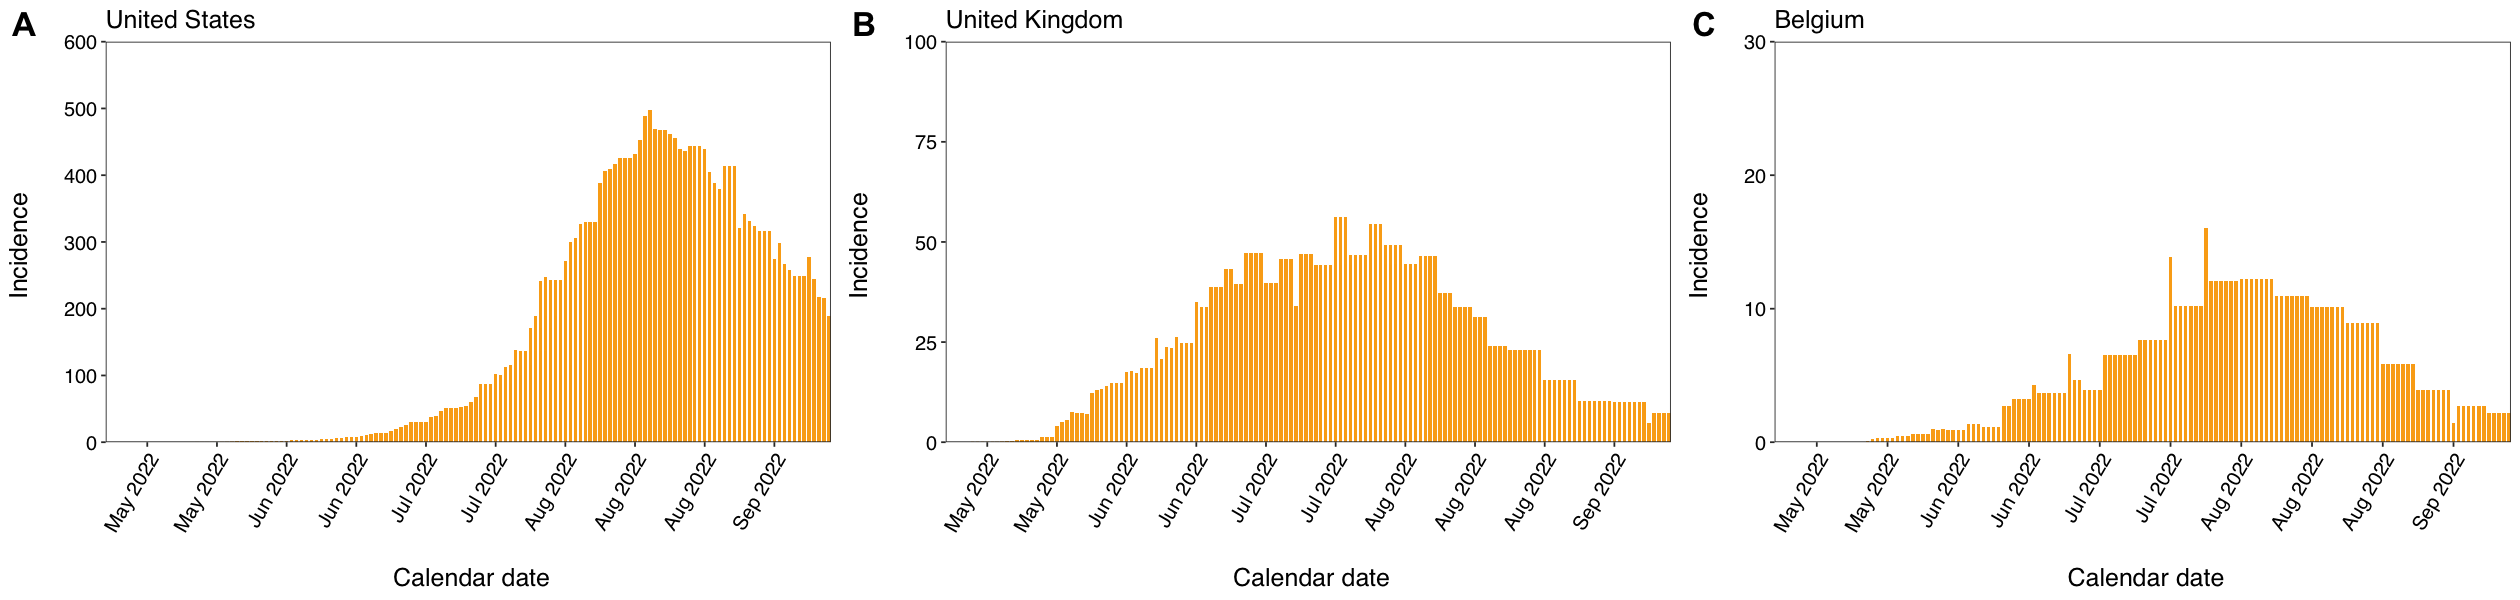

In [129]:
## checking the smoothened incidence with the 14-day moving average
options(repr.plot.width=7,repr.plot.height=5)
df_inci_MA %>% filter(location==c("United States")) %>%
    ggplot() + 
    geom_bar(aes(x=date, y=MA_new_cases), fill="#FAAB18" ,stat='identity', width=0.7) +
    ggtitle("United States") +
    labs(x="\n Calendar date", y="Incidence \n") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 12),
          legend.text = element_text(size = 11),
          plot.title = element_text(size=15, family="sans",color="black"),
          axis.text.x=element_text(angle=60, hjust=1)) +
scale_x_date(date_labels = "%b %Y", date_breaks = "2 weeks", expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,600)) -> Fig1

df_inci_MA %>% filter(location==c("United Kingdom")) %>%
    ggplot() + 
    geom_bar(aes(x=date, y=MA_new_cases), fill="#FAAB18" ,stat='identity', width=0.7) +
    ggtitle("United Kingdom") +
    labs(x="\n Calendar date", y="Incidence \n") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 12),
          legend.text = element_text(size = 11),
          plot.title = element_text(size=15, family="sans",color="black"),
          axis.text.x=element_text(angle=60, hjust=1)) +
scale_x_date(date_labels = "%b %Y", date_breaks = "2 weeks", expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,100)) -> Fig2

df_inci_MA %>% filter(location==c("Belgium")) %>%
    ggplot() + 
    geom_bar(aes(x=date, y=MA_new_cases), fill="#FAAB18" ,stat='identity', width=0.7) +
    ggtitle("Belgium") +
    labs(x="\n Calendar date", y="Incidence \n") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 12),
          legend.text = element_text(size = 11),
          plot.title = element_text(size=15, family="sans",color="black"),
          axis.text.x=element_text(angle=60, hjust=1)) +
scale_x_date(date_labels = "%b %Y", date_breaks = "2 weeks", expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,30)) -> Fig3

options(repr.plot.width=21,repr.plot.height=5)
ggarrange(Fig1, Fig2, Fig3, ncol = 3, nrow = 1, labels = c("A", "B", "C"), font.label = list(size = 20))

In [133]:
df_inci_MA %>% filter(iso_code==c("PRT"))

iso_code,location,region,sub_region,date,new_cases,total_cases,MA_new_cases,MA_total_cases,date_import,MSM_pop,pop2022,cum_icni_prop
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>
PRT,Portugal,Europe,Southern Europe,2022-05-01,0,0,0.0000000,0.0000000,2022-05-17,74187.61,10270.86,0.000000e+00
PRT,Portugal,Europe,Southern Europe,2022-05-02,0,0,0.0000000,0.0000000,2022-05-17,74187.61,10270.86,0.000000e+00
PRT,Portugal,Europe,Southern Europe,2022-05-03,0,0,0.0000000,0.0000000,2022-05-17,74187.61,10270.86,0.000000e+00
PRT,Portugal,Europe,Southern Europe,2022-05-04,0,0,0.0000000,0.0000000,2022-05-17,74187.61,10270.86,0.000000e+00
PRT,Portugal,Europe,Southern Europe,2022-05-05,0,0,0.0000000,0.0000000,2022-05-17,74187.61,10270.86,0.000000e+00
PRT,Portugal,Europe,Southern Europe,2022-05-06,0,0,0.0000000,0.0000000,2022-05-17,74187.61,10270.86,0.000000e+00
PRT,Portugal,Europe,Southern Europe,2022-05-07,0,0,0.0000000,0.0000000,2022-05-17,74187.61,10270.86,0.000000e+00
PRT,Portugal,Europe,Southern Europe,2022-05-08,0,0,0.0000000,0.0000000,2022-05-17,74187.61,10270.86,0.000000e+00
PRT,Portugal,Europe,Southern Europe,2022-05-09,0,0,0.0000000,0.0000000,2022-05-17,74187.61,10270.86,0.000000e+00
